# Adding light curves back together.

Jack Dinsmore, July 2020

In *isolating-variable-stars.ipynb*, we generated light curves for different chunks of the TPF of a certain cluster. Adding these light curves back together will help us understand what these chunk lightcurves represent. I hope that they yield a lightcurve similar to the cluster lightcurve, but if not, it shows something is wrong.

In part, this checks the validity of using the entire sky mask for background correction for a single chunk. The other option would be using only the part of the sky mask that is in the chunk.

This notebook shows very good agreement between the cluster lighcurves and the sum of the chunk lightcurves, which is good.

In [3]:
%matplotlib inline
import lightkurve as lk
import os
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import math
from scipy import stats

#CLUSTERS = ["NGC 752", "NGC 6231", "NGC 3532"]
CLUSTERS = ["NGC 6231"]#, "IC 2391"]
CLUSTERS = ["NGC 752", "IC 2391", "NGC 6231", "Lambda Orionis", "NGC 3532", "Omega Cen", "47 Tuc"]
#CLUSTERS = ["NGC 752", "M34"]
COORDS = {"M34":(40.53083, 42.74615), "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 2391": (130.133, -53.033), 
          "NGC 6231":(253.53546, -41.82667), "Lambda Orionis":(83.784490, 9.934156), "NGC 3532":(166.44923, -58.7705),
          "Collinder 140":("111.113000", "-31.850000"),
          "Omega Cen": (201.69121, -47.47686), "47 Tuc": (6.022329, -72.081444), "NGC 6752": (287.71575, -59.98185)}
LIGHTKURVE_CACHE = "/home/jtdinsmo/.lightkurve-cache/tesscut/"
NUMBER_PCA_COMPONENTS = 10

SCALE_FACTOR = 1.5
LOWER_LIMIT = 10

DIVISIONS = [2, 2]
FFI_SIZE = 180
CUTOFF_PERCENTILE = 3

Again, I'm going to use my maximum counting algorithm, just because all my other code has been written to use it.

In [4]:
def countMaxima(data):
    stars = 0
    
    def getValue(x, y):
        if x < 0 or x >= data.shape[0] or y < 0 or y >= data.shape[0]:
            return 0 # Count this pixel as automatically smaller than everything else
        if np.isnan(data[x][y]):
            return 0 # Count this pixel as automatically smaller than everything else.
        if data[x][y] < LOWER_LIMIT:
            return 0 # Count this pixel as automatically smaller than everything else.
        return data[x][y]
        
    for x in range(data.shape[0]):
        for y in range(data.shape[1]):
            b = data[x][y]
            if np.isnan(b): continue # Don't count nan pixels
            if b < LOWER_LIMIT: continue # Don't count pixels on edge of sector
            up = getValue(x, y-1)
            down = getValue(x, y+1)
            left = getValue(x-1, y)
            right = getValue(x+1, y)
            if b > max(up, down, left, right):
                stars += 1
    return stars

In [5]:
tpfs = [0]*len(CLUSTERS)

class Cluster:
    def __init__(self, name):
        self.name = name
        self.tpf = 0
        
        foundLocal = False
        for file in os.listdir(LIGHTKURVE_CACHE):
            if file.endswith("180x180_astrocut.fits"): # Confirm size
                if COORDS[name][0] == float(file.split("_")[-4]): # Confirm RA
                    if COORDS[name][1] == float(file.split("_")[-3]): # Confirm dec
                        self.tpf = lk.TessTargetPixelFile(LIGHTKURVE_CACHE + file)
                        foundLocal = True
                        break
        if not foundLocal:
            search = lk.search_tesscut(name)
            char = ""
            if len(search) != 1: char = "s"
            print("{0} has {1} result{2}.".format(self.name, len(search), char))
            self.tpf = search[0].download(cutout_size=180)
        
        #self.image = self.tpf[self.tpf.flux.shape[0] // 2].flux.reshape((180, 180))
        self.image = np.mean(self.tpf.flux, axis=0)
        self.upperLimit = None
        
        
    def getLimitMaximaMethod(self):
        numMaxima = countMaxima(self.image)
        notNanMask = ~np.isnan(self.image)
        notEdgeMask = self.image > LOWER_LIMIT
        numPixels = np.count_nonzero(notNanMask & notEdgeMask) # Count the number of pixels that
            # are not nan and are greater than LOWER_LIMIT.
        n = 100 - SCALE_FACTOR * numMaxima / numPixels * 100
        self.upperLimit = np.nanpercentile(self.image, n)# Upper limit of the sky pixel flux range
        print("{0} maxima: {1} / {2} = {3}%. n={4}".format(self.name, numMaxima, numPixels, numMaxima / numPixels*100, n))
        
    
    def getMasks(self):
        self.getLimitMaximaMethod()
        #self.getLimitBinMethod()
        self.skyMask = ((self.image >= LOWER_LIMIT) & # Exclude edge pixels
            (self.image <= self.upperLimit)).reshape(180, 180).astype(bool)
        self.starMask = ((self.image > self.upperLimit)).reshape(180, 180).astype(bool)
        
        
    def generateLightcurves(self):
        rootLC = self.tpf.to_lightcurve(aperture_mask=self.starMask)
        regressor = self.tpf.flux[:, self.skyMask]# The regressor is the inverse of the aperture

        dm = lk.DesignMatrix(regressor, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
        corrector = lk.RegressionCorrector(rootLC)
        self.correctedRootLC = corrector.correct(dm)
        
        self.correctedLCs = []
        self.qs = []
        for x in range(DIVISIONS[0]):
            lineLC = []
            lineQs = []
            for y in range(DIVISIONS[1]):
                tempStarMask = np.zeros_like(self.starMask)
                tempStarMask[int(FFI_SIZE / DIVISIONS[0] * x) : int(FFI_SIZE / DIVISIONS[0] * (x+1)),
                                  int(FFI_SIZE / DIVISIONS[1] * y) : int(FFI_SIZE / DIVISIONS[1] * (y+1))] = \
                self.starMask[int(FFI_SIZE / DIVISIONS[0] * x) : int(FFI_SIZE / DIVISIONS[0] * (x+1)),
                                  int(FFI_SIZE / DIVISIONS[1] * y) : int(FFI_SIZE / DIVISIONS[1] * (y+1))]
                
                lc = self.tpf.to_lightcurve(aperture_mask=tempStarMask)

                #regressor = self.tpf.flux[:, self.skyMask]# The regressor is the inverse of the aperture

                #dm = lk.DesignMatrix(regressor, name='regressors').pca(NUMBER_PCA_COMPONENTS).append_constant()
                corrector = lk.RegressionCorrector(lc)
                correctedLC = corrector.correct(dm)
                
                lowCutoff = np.nanpercentile(correctedLC.flux, CUTOFF_PERCENTILE)
                highCutoff = np.nanpercentile(correctedLC.flux, 100 - CUTOFF_PERCENTILE)
                q = (lowCutoff < correctedLC.flux) & (correctedLC.flux < highCutoff)
                #correctedLC.time = correctedLC.time[q]
                #correctedLC.flux = correctedLC.flux[q]
                
                lineQs.append(q)
                lineLC.append(correctedLC)
                
            self.correctedLCs.append(lineLC)
            self.qs.append(lineQs)
            
    
    def displayFluxHistograms(self):
        r = max(self.correctedRootLC.flux) - min(self.correctedRootLC.flux)
        maxRange = r / np.nanmean(self.correctedRootLC.flux)
        # Get the maximum range
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                r = max(self.correctedLCs[x][y].flux) - min(self.correctedLCs[x][y].flux)
                maxRange = max(maxRange, r / np.nanmean(self.correctedLCs[x][y].flux))
                
        # Draw full image hist
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,2.2]})
        a = ax1.imshow(self.image, vmax=np.nanpercentile(self.image, 95))
        ax1.set_title("{0}: (Full image)".format(self.name))
        plt.colorbar(a, ax=ax1)

        mean = np.nanmean(self.correctedRootLC.flux)
        minBin = mean - maxRange  * mean / 2
        maxBin = mean + maxRange  * mean / 2
        bins = np.arange(minBin, maxBin, maxRange  * mean / 100)
        ax2.hist(self.correctedRootLC.flux, bins=bins)
        ax2.set_title("Histogram of fluxes for {0}.".format(self.name));
        ax2.set_xlabel("Flux value")
        ax2.set_ylabel("Flux counts")
                
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,4), gridspec_kw={'width_ratios':[1,2.2]})
                image= self.image[int(FFI_SIZE / DIVISIONS[0] * x) : int(FFI_SIZE / DIVISIONS[0] * (x+1)),
                                  int(FFI_SIZE / DIVISIONS[1] * y) : int(FFI_SIZE / DIVISIONS[1] * (y+1))]
                a = ax1.imshow(image, vmax=np.nanpercentile(image, 95))
                ax1.set_title("{0}: ({1}, {2})".format(self.name, x, y))
                plt.colorbar(a, ax=ax1)
                
                mean = np.nanmean(self.correctedLCs[x][y].flux)
                minBin = mean - maxRange  * mean / 2
                maxBin = mean + maxRange  * mean / 2
                bins = np.arange(minBin, maxBin, maxRange  * mean / 100)
                ax2.hist(self.correctedLCs[x][y].flux, bins=bins)
                ax2.set_title("Histogram of fluxes for {0}.".format(self.name));
                ax2.set_xlabel("Flux value")
                ax2.set_ylabel("Flux counts")
                
                
    def displayTPFs(self):
        fig, ax = plt.subplots(ncols=1, figsize=(4, 4))
        a = ax.imshow(self.image, vmax=np.nanpercentile(self.image, 95))
        ax.set_title("{0}: (Full image)".format(self.name))
        plt.colorbar(a, ax=ax)
        
        fig, ax = plt.subplots(DIVISIONS[0], DIVISIONS[1], sharex='col', sharey='row', figsize=(10,10))
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                image= self.image[int(FFI_SIZE / DIVISIONS[0] * x) : int(FFI_SIZE / DIVISIONS[0] * (x+1)),
                                  int(FFI_SIZE / DIVISIONS[1] * y) : int(FFI_SIZE / DIVISIONS[1] * (y+1))]
                a = ax[x, y].imshow(image, vmax=np.nanpercentile(image, 95))
                #plt.colorbar(a, ax=ax[x, y])
        
    
    def displayLightcurves(self):
        fig, ax = plt.subplots(ncols=1, figsize=(16,4))
        self.correctedRootLC.scatter(ax=ax, color='k');
        ax.set_title("TESS 2-min lightcurve for {0}, corrected.".format(self.name));
        
        fig, ax = plt.subplots(DIVISIONS[0], DIVISIONS[1], figsize=(16,8))
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                self.correctedLCs[x][y].scatter(ax=ax[x, y], color='k');
                ax[x, y].set_xlabel("");
                ax[x, y].set_ylabel("");
                
    
    def sumLightcurves(self):
        flux = [0]*len(self.correctedRootLC.time)
        time = self.correctedRootLC.time[:]
        for x in range(DIVISIONS[0]):
            for y in range(DIVISIONS[1]):
                flux += self.correctedLCs[x][y].flux
                
        
        fig, ax = plt.subplots(ncols=1, figsize=(16,4))
        self.correctedRootLC.plot(ax=ax, color='b', label="Original");
        ax.plot(time, flux, color='darkorange', linestyle='dashed', label="Sum");
        ax.set_title("Light curve comparison for {0}".format(self.name));
        plt.legend();

NGC 752 maxima: 1402 / 32400 = 4.327160493827161%. n=93.50925925925925
IC 2391 maxima: 2094 / 32400 = 6.462962962962964%. n=90.30555555555556
NGC 6231 maxima: 2643 / 32400 = 8.157407407407408%. n=87.76388888888889
Lambda Orionis maxima: 1666 / 32400 = 5.1419753086419755%. n=92.28703703703704
NGC 3532 maxima: 1951 / 32400 = 6.021604938271604%. n=90.9675925925926
Omega Cen maxima: 2227 / 32400 = 6.873456790123457%. n=89.68981481481481
47 Tuc maxima: 2271 / 32400 = 7.0092592592592595%. n=89.48611111111111


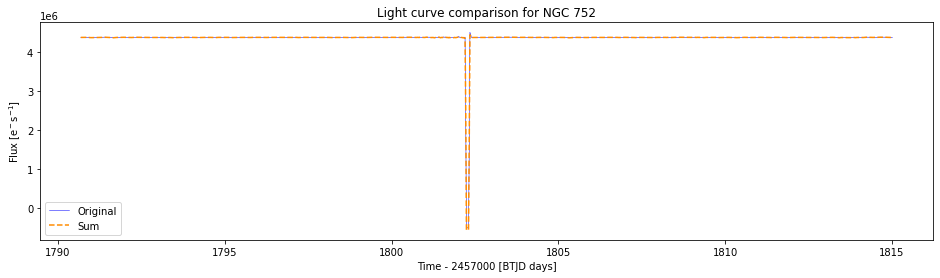

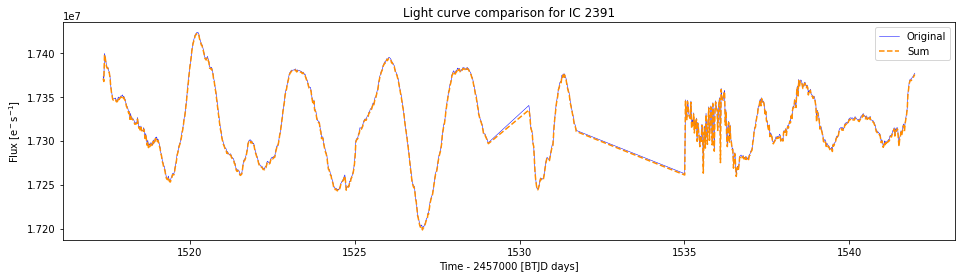

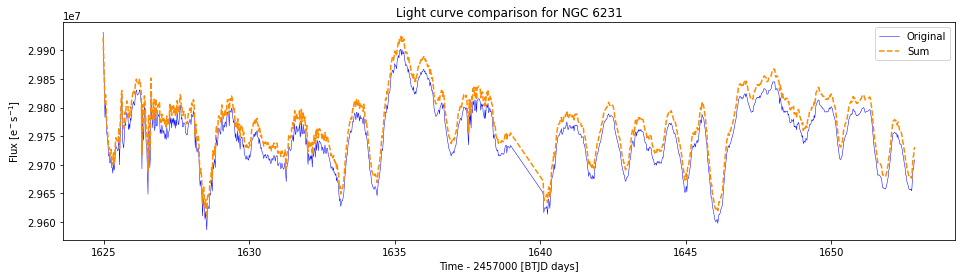

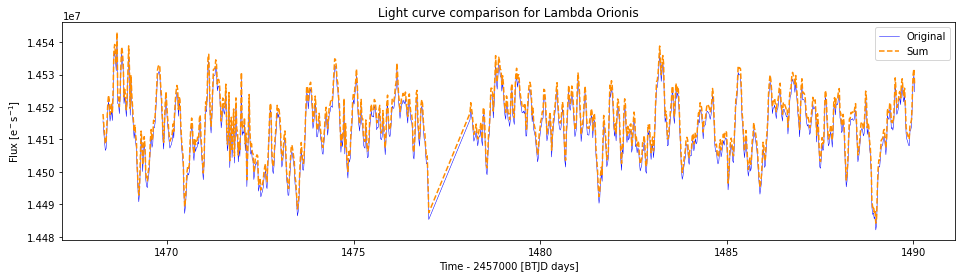

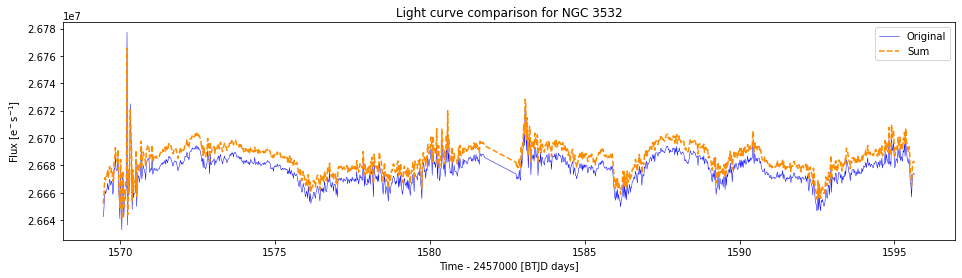

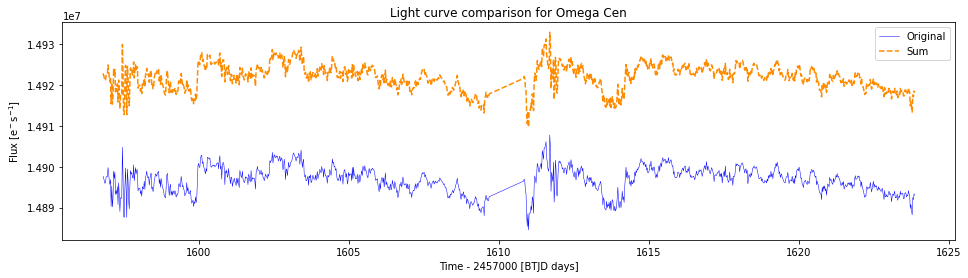

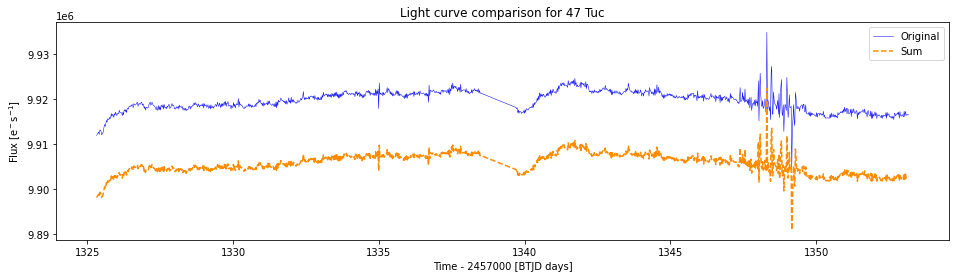

In [6]:
for c in CLUSTERS:
    cl = Cluster(c)
    cl.getMasks()
    cl.generateLightcurves()
    #cl.displayTPFs()
    #cl.displayLightcurves()
    cl.sumLightcurves()

## Conclusion:

They add up, even though I thought they wouldn't. Yeah boi.